In [1]:
import torch
from fastai.vision.all import *

path = Path('./animals_dataset/train')

# Rebuild DataLoaders on CPU
dls = ImageDataLoaders.from_folder(
    path,
    train='.',
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    bs=64
)

print(f"Number of classes: {len(dls.vocab)}")
print(f"Classes: {dls.vocab}")
print(f"Training samples: {len(dls.train_ds)}")
print(f"Validation samples: {len(dls.valid_ds)}")


Number of classes: 5
Classes: ['capybara', 'cat', 'dog', 'owl', 'rabbit']
Training samples: 509
Validation samples: 127


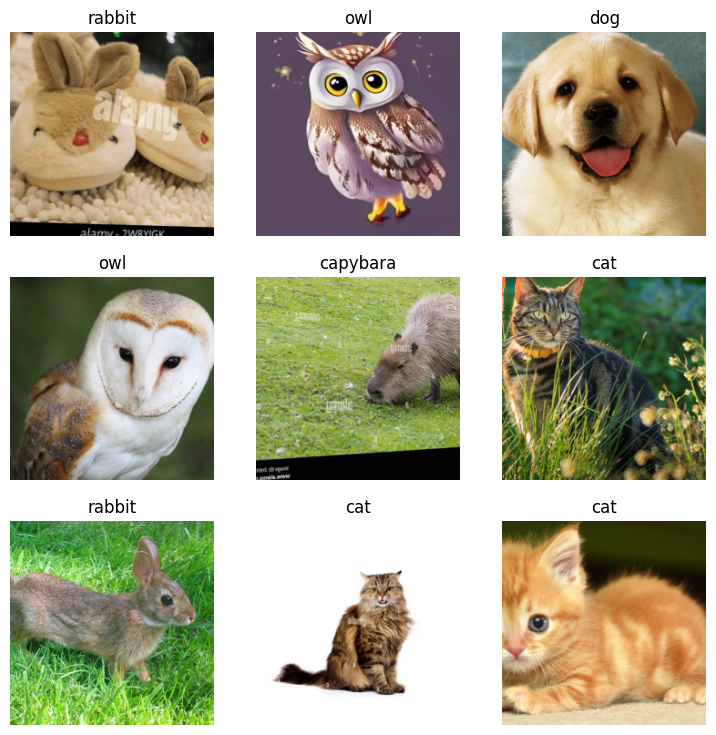

In [2]:
dls.show_batch(max_n=9)

In [3]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(valley=0.0008317637839354575)

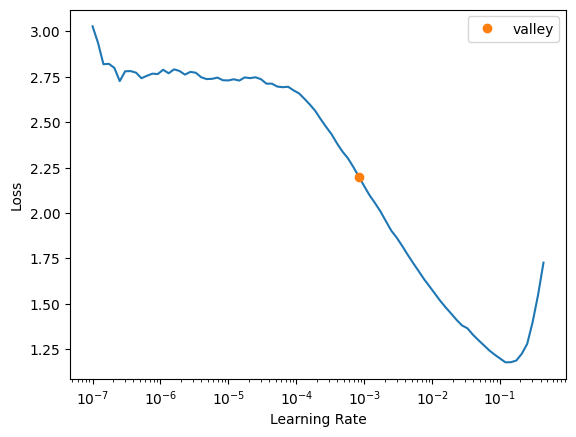

In [4]:
learn.lr_find()

In [5]:
lr = 0.0008317637839354575
epochs =  5

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.952281,0.692442,0.259842,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.791312,0.380841,0.118110,00:19
1,0.673369,0.276412,0.086614,00:20
2,0.536748,0.246886,0.070866,00:18
3,0.449660,0.238186,0.070866,00:18
4,0.386320,0.232863,0.062992,00:19


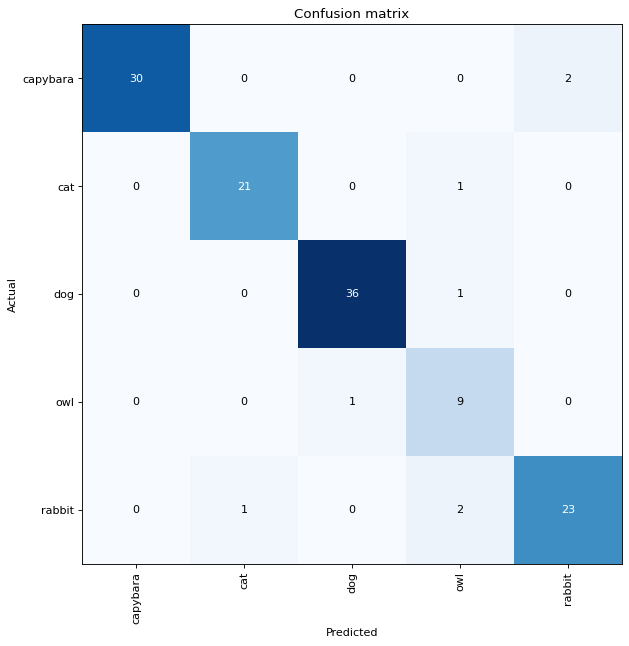

In [7]:
# Create interpretation object
interp = ClassificationInterpretation.from_learner(learn)

# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(8, 8), dpi=80)

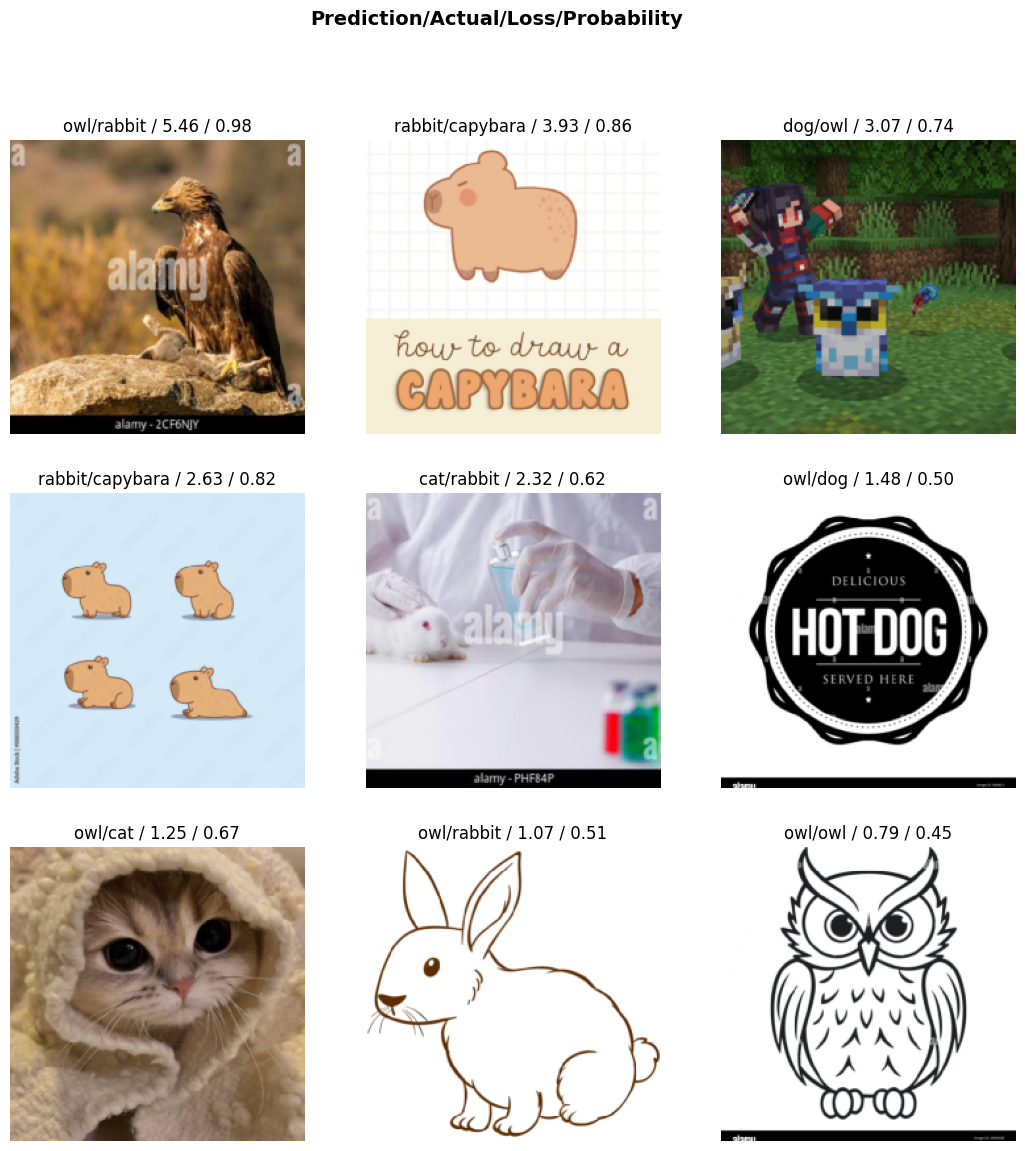

In [8]:
interp.plot_top_losses(9, figsize=(13, 13))

In [9]:
test_path = Path('./animals_dataset/test')
test_dl = learn.dls.test_dl(get_image_files(test_path))

print(f"Test set size: {len(test_dl.items)}")


Test set size: 215


In [10]:
# Create a test DataLoader
test_path = Path('./animals_dataset/test' )
test_dl = learn.dls.test_dl(get_image_files(test_path))
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]
# Calculate test accuracy
from statistics import mean

test_accuracy = mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)])
test_error_rate = 1 - test_accuracy

print(f"\nTEST RESULTS:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Error Rate: {test_error_rate:.4f} ({test_error_rate*100:.2f}%)")

# Per-class accuracy
print(f"\nPER-CLASS RESULTS:")
for class_name in class_names:
    class_true = [i for i, true_class in enumerate(true_class_names) if true_class == class_name]
    if len(class_true) > 0:
        class_correct = sum([true_class_names[i] == pred_class_names[i] for i in class_true])
        class_accuracy = class_correct / len(class_true)
        print(f"{class_name:10}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%) - {class_correct}/{len(class_true)} correct")


TEST RESULTS:
Test Accuracy: 0.9442 (94.42%)
Test Error Rate: 0.0558 (5.58%)

PER-CLASS RESULTS:
capybara  : 0.9773 (97.73%) - 43/44 correct
cat       : 0.8810 (88.10%) - 37/42 correct
dog       : 0.9773 (97.73%) - 43/44 correct
owl       : 0.9500 (95.00%) - 38/40 correct
rabbit    : 0.9333 (93.33%) - 42/45 correct


## 💾 Export Model for HuggingFace Deployment

In [ ]:
learn.path = Path('./')  # set path for saving model
learn.export('model.pkl')

In [ ]:
# Test loading the exported model
def test_load_model():
    """Test if the exported model can be loaded successfully"""
    try:
        test_learn = load_learner('model.pkl', cpu=True)
        print("✅ Model loads successfully with load_learner")
        return test_learn
    except Exception as e:
        print(f"load_learner failed: {e}")
        try:
            # Try alternative loading
            with open('model.pkl', 'rb') as f:
                test_learn = pickle.load(f)
            print("✅ Model loads with pickle")
            return test_learn
        except Exception as e2:
            print(f"Pickle loading failed: {e2}")
            return None

# Test the exported model
test_model = test_load_model()
if test_model:
    print("✅ Export successful and verified!")
else:
    print("❌ Export verification failed")

In [ ]:
image_path = Path('animals_dataset/test/cat/image10.jpg')

# Predict the class of the new image
prediction, prediction_idx, probabilities = learn.predict(image_path)

# Print the prediction result
print(f'Prediction: {prediction}')
print(f'Index of the predicted class: {prediction_idx}')
print(f'Probabilities: {probabilities}')

In [ ]:
import gradio as gr  # Importing Gradio for creating the web interface

# Extract categories (class labels) from the DataLoader
categories = learn.dls.vocab

# Function to classify an image
def classify_image(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))  # Map categories to their probabilities

# Define Gradio input and output components using the updated API
image = gr.Image(width=224, height=224)  # Image input with fixed shape
label = gr.Label()  # Output label to display classification
examples = [image_path]  # Path to image(s) for demonstration

# Create and launch the Gradio interface
intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(share=True)

## 🚀 Prepare files for HuggingFace Deployment

Now let's copy the model and example images to the gradio_app folder for deployment.

In [ ]:
import shutil
from pathlib import Path

# Create gradio_app folder if it doesn't exist
gradio_folder = Path('gradio_app')
gradio_folder.mkdir(exist_ok=True)

# Copy the model
model_path = Path('model.pkl')
if model_path.exists():
    shutil.copy(model_path, gradio_folder / 'model.pkl')
    print(f"✅ Copied model.pkl to {gradio_folder}/")
else:
    print(f"❌ model.pkl not found! Please run the export cell first.")

# Copy some example images
examples_to_copy = [
    ('animals_dataset/test/cat/image10.jpg', 'example1.jpg'),
    ('animals_dataset/test/dog/image5.jpg', 'example2.jpg'),
    ('animals_dataset/test/owl/image3.jpg', 'example3.jpg'),
]

for src, dst in examples_to_copy:
    src_path = Path(src)
    if src_path.exists():
        shutil.copy(src_path, gradio_folder / dst)
        print(f"✅ Copied {dst}")
    else:
        print(f"⚠️  {src} not found, skipping")

print(f"\n🎉 All files ready in {gradio_folder}/ folder!")
print(f"\n📁 Files to upload to HuggingFace:")
print(f"   - app.py")
print(f"   - requirements.txt") 
print(f"   - model.pkl")
print(f"   - example1.jpg, example2.jpg, example3.jpg (optional)")
print(f"\n📖 See {gradio_folder}/README.md for deployment instructions!")